In [770]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re

%matplotlib inline

In [340]:
sns.set_context(context = 'paper',font_scale = 2)

In [619]:
df = pd.read_csv('/Users/alexisrutherford/Desktop/fow_game/jobSkillMat.csv',delimiter='\t')
isTasks = True
jobsTasksDf = df.iloc[:,:2]
df = df.iloc[:,2:]

In [620]:
df = pd.read_csv('job_skill_matrix/job_skill_matrix_combined.csv')
## Full data
isTasks = False
jobsDf = df.iloc[:,:2]
df = df.iloc[:,2:]

In [342]:
df.head()

2.A.1.a  2.A.1.b  2.A.1.c  2.A.1.d  2.A.1.e  2.A.1.f  2.A.2.a  2.A.2.b  \
0     4.12     4.12     4.00     4.38     3.25     1.88     4.38     4.00   
1     4.00     3.88     3.88     4.00     2.75     1.75     4.00     3.50   
2     3.88     4.00     3.25     4.00     2.38     1.88     3.88     3.50   
3     3.75     4.00     3.75     4.00     3.00     1.50     3.75     3.25   
4     3.88     3.88     3.25     3.88     2.75     1.75     3.88     3.88   

   2.A.2.c  2.A.2.d  ...  2.C.7.a  2.C.7.b  2.C.7.c  2.C.7.d  2.C.7.e  \
0     3.12     4.12  ...     4.07     1.56     1.43     1.48     1.70   
1     3.38     3.62  ...     3.81     1.40     1.38     1.80     1.85   
2     3.00     4.00  ...     3.71     1.62     1.16     1.21     1.51   
3     2.75     3.25  ...     4.35     1.68     2.90     1.34     1.47   
4     3.12     3.75  ...     4.48     1.64     1.70     1.68     1.64   

   2.C.8.a  2.C.8.b  2.C.9.a  2.C.9.b  2.C.10  
0     3.30     3.92     1.76     2.70    2.21  
1     2.40     2.88     1.58     2.84    2.42  
2     3.10     2.95     2.50     2.59    2.20  
3     1.78     1.87     3.06     4.33    1.61  
4     2.50     2.86     2.86     3.80    1.68  

[5 rows x 120 columns]

In [621]:
jobsTasksDf.head()

Job Code                                          Job Title
0  13-2011                           accountants and auditors
1  27-2011                                             actors
2  15-2011                                          actuaries
3  51-9191     adhesive bonding machine operators and tenders
4  23-1021  administrative law judges, adjudicators, and h...

In [611]:
jobsDf.head()

Job Code                                          Job Title
0  13-2011                           accountants and auditors
1  27-2011                                             actors
2  15-2011                                          actuaries
3  51-9191     adhesive bonding machine operators and tenders
4  23-1021  administrative law judges, adjudicators, and h...

In [630]:
jobsDf.columns = ['n','Job Code']

In [631]:
jobsDf['Job Code'] = jobsDf['Job Code'].astype('str')

In [618]:
jobsDf.iloc[:,1] = jobsDf.iloc[:,1].apply(lambda x:x[:-3])

In [632]:
jobsTasksDf['Job Code'] = jobsTasksDf['Job Code'].astype('str')

In [642]:
jobsTasksDf.set_index('Job Code',inplace = True)

In [645]:
jobDict = jobsTasksDf.to_dict(orient = 'index')

## Quick Exploration

In [646]:
ii

9193

'Demonstrators and product promoters'

Randomly selected 17712


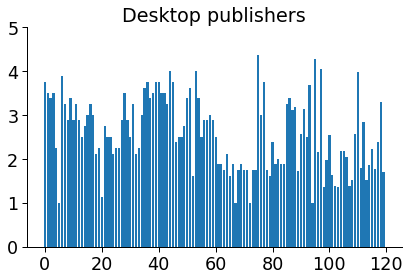

Randomly selected 19896


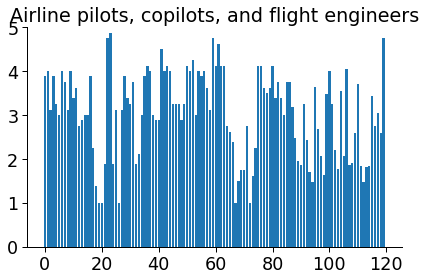

Randomly selected 22647


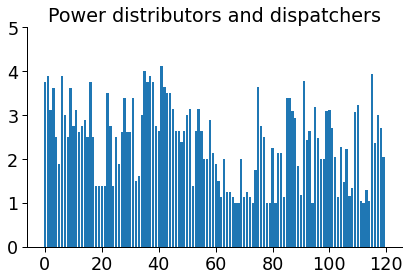

In [680]:
iis = [17712,19896,22647]


for i in range(3):
    ii = random.randint(0,df.shape[0] - 1)
    ii = iis[i]
    print('Randomly selected',ii)
    
    fig, ax = plt.subplots()
    
    plt.bar(range(df.shape[1]),df.iloc[ii,:].values)
    
    if isTasks:
        plt.ylim(0,1.1)
    else:
        plt.ylim(0,5.0)
    plt.title(jobDict[jobsDf.iloc[ii,1][:-3]][' Job Title'].capitalize())
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('figs/random_example_projection_{:d}.png'.format(ii),dpi = 300)
    plt.show()

### Distribution of max values of features

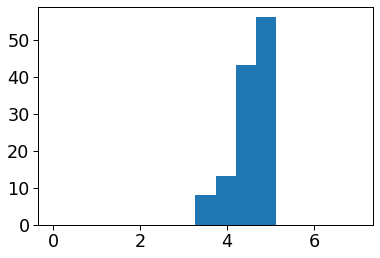

In [345]:
if isTasks:
    plt.hist(df.max(),bins = np.linspace(0,1,11))
else:
    plt.hist(df.max(),bins = np.linspace(0,7,16))

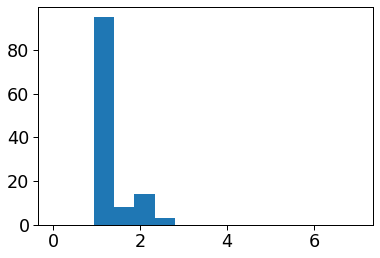

In [346]:
_ = plt.hist(df.min(),bins = np.linspace(0,7,16))

l =  10
isTasks = False


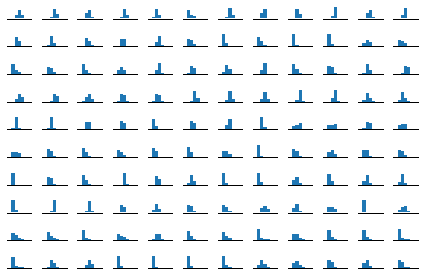

In [657]:
l = np.floor(np.sqrt(df.shape[1]))
l = int(np.ceil(l))

print('l = ',l)

#isTasks = True

if isTasks:
    print('isTasks = True')
    bins = np.linspace(0,1,11)
    yMax = 400
    yMin = -40
    nFeatures = 120
    ll = l +1
else:
    print('isTasks = False')
    bins = np.linspace(0,7,8)
    yMax = 20000
    yMin = -200
    nFeatures = 230
    ll = l + 2
    
for i in range(df.shape[1]):
    ax = plt.subplot(l, ll, i+1)
    
    plt.hist(df.iloc[:,i].values,bins = bins)
    plt.ylim(yMin,yMax)
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.tight_layout()

if isTasks:
    plt.savefig('figs/features_hist_tasks_all.png',dpi = 300)
else:
    plt.savefig('figs/features_hist_skills_all.png',dpi = 300)

## Try some scaling

In [544]:
scaler = StandardScaler()

In [545]:
scaler.fit(df)

StandardScaler()

In [546]:
dfScaled = pd.DataFrame(data = scaler.transform(df))

l =  10
isTasks = False


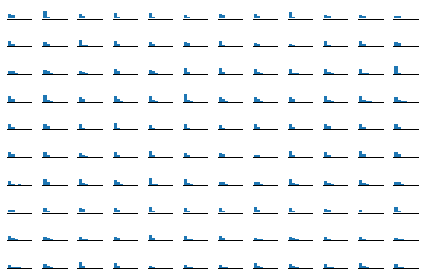

In [658]:
l = np.floor(np.sqrt(df.shape[1]))
l = int(np.ceil(l))

print('l = ',l)

#isTasks = True

if isTasks:
    print('isTasks = True')
    bins = np.linspace(0,1,11)
    yMax = 100
    yMin = -10
    nFeatures = 120
    ll = l +1
else:
    print('isTasks = False')
    bins = np.linspace(0,7,8)
    yMax = 20000
    yMin = -200
    nFeatures = 230
    ll = l + 2
    
for i in range(df.shape[1]):
    ax = plt.subplot(l, ll, i+1)
    
    plt.hist(dfScaled.iloc[:,i].values,bins = bins)
    plt.ylim(yMin,yMax)
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.tight_layout()
    
if isTasks:
    plt.savefig('features_hist_tasks_all_scaled.png',dpi = 300)
else:
    plt.savefig('features_hist_skills_all_scaled.png',dpi = 300)

In [659]:
jobsDf

n    Job Code
0        0  11-1011.00
1        1  11-1011.03
2        2  11-1021.00
3        3  11-2011.00
4        4  11-2021.00
...    ...         ...
24667  962  53-7072.00
24668  963  53-7073.00
24669  964  53-7081.00
24670  965  53-7111.00
24671  966  53-7121.00

[24672 rows x 2 columns]

In [ ]:
encoder.

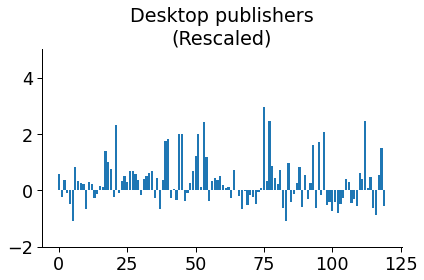

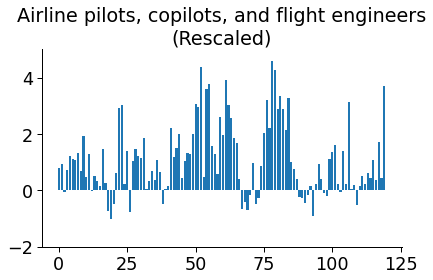

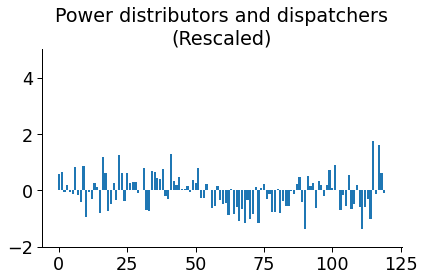

In [679]:
iis = [17712,19896,22647]

for i in range(3):
    fig, ax = plt.subplots()

    plt.bar(range(df.shape[1]),dfScaled.iloc[iis[i],:].values)
    
    if isTasks:
        #plt.ylim(0,1.1)
        pass
    else:
        plt.ylim(-2,5.0)
        pass
    
    plt.title(jobDict[jobsDf.iloc[iis[i],1][:-3]][' Job Title'].capitalize()+'\n(Rescaled)')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('figs/random_example_projection_{:d}_scaled.png'.format(iis[i]),dpi = 300)
    plt.show()

## Encoder

In [552]:
nFeatures = df.shape[1]

input_data = tf.keras.layers.Input(shape=(nFeatures, ))

In [550]:
nLatent = 4

In [554]:
if isTasks:
    encoder = tf.keras.layers.Dense(nLatent)(input_data)
    # Single layer for now
else:
    #x = tf.keras.layers.Dense(nLatent)(input_data)
    #encoder = layers.Dense(16, activation="relu")(x)
    encoder = tf.keras.layers.Dense(nLatent)(input_data)

In [555]:
def sample_latent_features(distribution):
    
    distribution_mean, distribution_variance = distribution
    
    batch_size = tf.shape(distribution_variance)[0]
    
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

In [556]:
distribution_mean = tf.keras.layers.Dense(nLatent, name='mean')(encoder)
distribution_variance = tf.keras.layers.Dense(nLatent, name='log_variance')(encoder)
latent_encoding = tf.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [557]:
encoder_model = tf.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 4)            484         input_16[0][0]                   
__________________________________________________________________________________________________
mean (Dense)                    (None, 4)            20          dense_17[0][0]                   
__________________________________________________________________________________________________
log_variance (Dense)            (None, 4)            20          dense_17[0][0]                   
___________________________________________________________________________________________

In [701]:
#out = encoder_model.call(tf.convert_to_tensor(df.iloc[:,2:].values.astype(float)))
out = encoder_model.call(tf.convert_to_tensor(dfScaled.values.astype(float)))


In [665]:
out = encoder_model.call(tf.convert_to_tensor(dfScaled.iloc[iis,:].values.astype(float)))

In [675]:
o = K.print_tensor(out,message = 'Values : ')

In [702]:
with tf.Session() as sess:  
    print(o.eval()) 

FailedPreconditionError: Error while reading resource variable mean_19/bias from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/mean_19/bias)
	 [[node mean_21/BiasAdd/ReadVariableOp (defined at Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'mean_21/BiasAdd/ReadVariableOp':
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
    await self.process_one()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 446, in process_one
    await dispatch(*args)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
    await result
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
    reply_content = await reply_content
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
    return runner(coro)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3173, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "var/folders/k1/53y5f3kj0ds7q7r6fdjsn2kc0000gn/T/ipykernel_19249/2438468739.py", line 1, in <module>
    out = encoder_model.call(tf.convert_to_tensor(dfScaled.iloc[iis,:].values.astype(float)))
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/network.py", line 695, in call
    return self._run_internal_graph(inputs, training=training, mask=mask)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/network.py", line 844, in _run_internal_graph
    output_tensors = layer(computed_tensors, **kwargs)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/core.py", line 1052, in call
    outputs = nn.bias_add(outputs, self.bias)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_ops.py", line 2717, in bias_add
    bias = ops.convert_to_tensor(bias, dtype=value.dtype, name="bias")
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1184, in convert_to_tensor
    return convert_to_tensor_v2(value, dtype, preferred_dtype, name)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1242, in convert_to_tensor_v2
    as_ref=False)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1297, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 1789, in _dense_var_to_tensor
    return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 1214, in _dense_var_to_tensor
    return self.value()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 524, in value
    return self._read_variable_op()
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 608, in _read_variable_op
    self._dtype)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_resource_variable_ops.py", line 587, in read_variable_op
    "ReadVariableOp", resource=resource, dtype=dtype, name=name)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


## Decoder

In [559]:
decoder_input = tf.keras.layers.Input(shape=(nLatent))

In [560]:
decoder_output = tf.keras.layers.Dense(nFeatures)(decoder_input)

In [561]:
decoder_model = tf.keras.Model(decoder_input, decoder_output)

In [562]:
decoder_model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [563]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tf.keras.models.Model(input_data, decoded)
autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
model_22 (Model)             (None, 4)                 524       
_________________________________________________________________
model_23 (Model)             (None, 120)               600       
Total params: 1,124
Trainable params: 1,124
Non-trainable params: 0
_________________________________________________________________


## Make Loss Function

In [564]:
def get_loss(dist_mean,dist_var):
    def get_reconstruction_loss(y_true,y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true,y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*df.shape[1] 
    
    def get_kl_loss(dist_mean,dist_var):
        kl_loss = 1 + dist_var - tf.square(dist_mean) - tf.exp(dist_var)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true,y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true,y_pred)
        kl_loss_batch = get_kl_loss(dist_mean,dist_var)
        return reconstruction_loss_batch + kl_loss_batch
    return total_loss

In [565]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')

In [87]:
train_data = tf.convert_to_tensor(df.iloc[0:700,2:].values.astype(float))
test_data = tf.convert_to_tensor(df.iloc[701:,2:].values.astype(float))

In [566]:
nn = int(dfScaled.shape[0]*0.9)

train_data = tf.convert_to_tensor(dfScaled.iloc[0:nn,:].values.astype(float))
test_data = tf.convert_to_tensor(dfScaled.iloc[nn:,:].values.astype(float))

In [ ]:
if isTasks:
    steps_per_epoch = 1000
    batch_size = 128
    epochs = 20
else:
    steps_per_epoch = 1000
    batch_size = 256
    epochs = 20

autoencoder.fit(train_data, train_data, epochs=epochs, batch_size=256, validation_data=(test_data, test_data),steps_per_epoch=1000,\
                validation_steps=30)

## Test

In [688]:
df = dfScaled
trial_data = df.iloc[7:9,:].values.astype(float)

In [684]:
trial_data = df.iloc[4:6,2:].values.astype(float)

In [686]:
trial_data_tf = tf.convert_to_tensor(trial_data)

In [515]:
output = autoencoder.predict(trial_data_tf,steps=10)

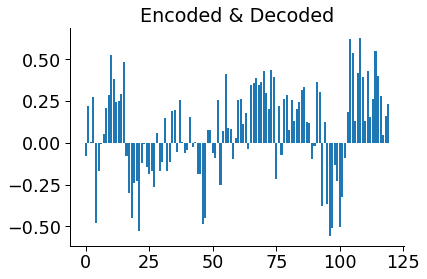

In [681]:
fig, ax = plt.subplots()


plt.bar(range(len(output[0])),output[0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Encoded & Decoded')
plt.savefig('figs/example_encoded_decoded.png',dpi = 300)

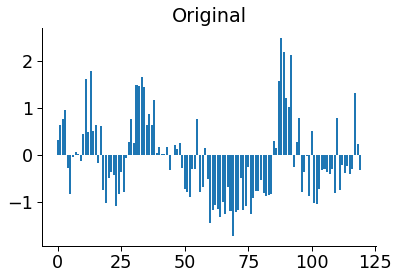

In [689]:
fig, ax = plt.subplots()


plt.bar(range(len(output[0])),trial_data[0,:])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Original')
plt.savefig('figs/example_original.png',dpi = 300)

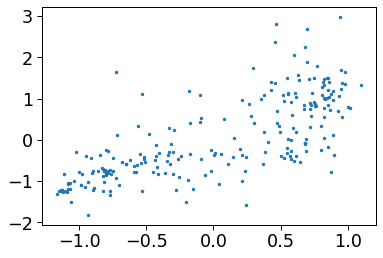

In [519]:
plt.plot(output[0],trial_data[0,:],'.')

## Transform it back

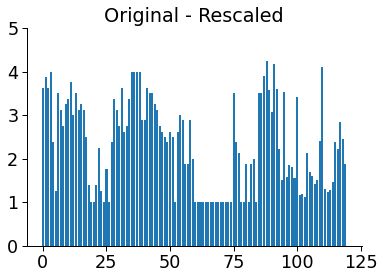

In [696]:
fig, ax = plt.subplots()


plt.bar(range(len(output[0])),scaler.inverse_transform([trial_data[0,:]])[0])
plt.title('Original - Rescaled')

if isTasks:
    plt.ylim(0,1.1)
else:
    plt.ylim(0,5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figs/example_original_rescaled.png',dpi = 300)

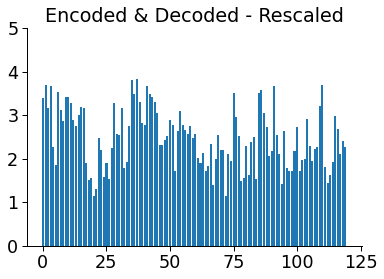

In [697]:
fig, ax = plt.subplots()


plt.bar(range(len(output[0])),scaler.inverse_transform([output[0]])[0])
plt.title('Encoded & Decoded - Rescaled')

if isTasks:
    plt.ylim(0,1.1)
else:
    plt.ylim(0,5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figs/example_encoded_decoded_rescaled.png',dpi = 300)

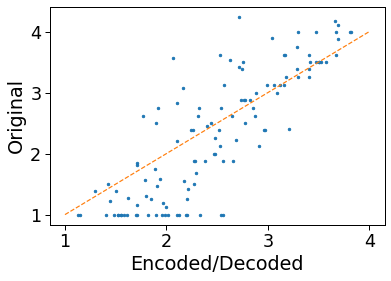

In [698]:
plt.plot(scaler.inverse_transform([output[0]])[0],scaler.inverse_transform([trial_data[0,:]])[0],'.')

plt.xlabel('Encoded/Decoded')
plt.ylabel('Original')

if isTasks:
    plt.plot([0,1],[0,1],'--')

else:
    plt.plot([1,4],[1,4],'--')


In [448]:
distance.cosine(scaler.inverse_transform([output[1]])[0],scaler.inverse_transform([trial_data[1,:]])[0])

0.007045910387502352

## Sample Latent Features

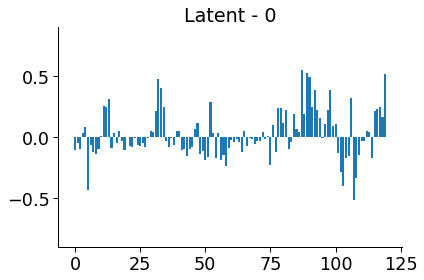

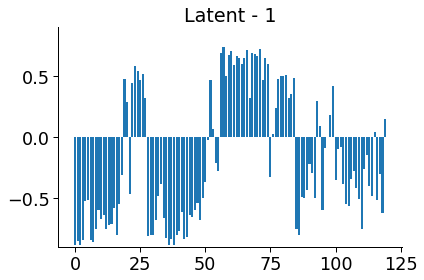

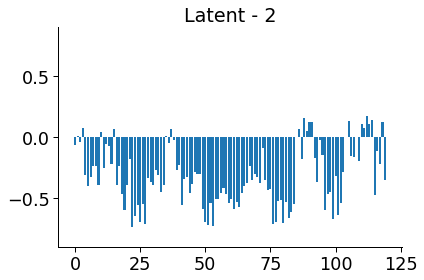

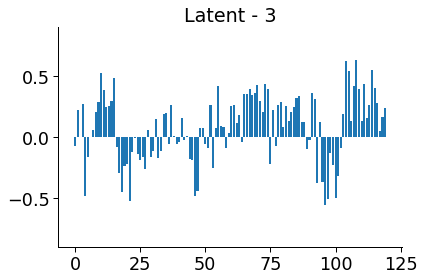

In [693]:
for n in range(nLatent):
    inZeros = np.array([[0]*nLatent])
    inZeros[0,n] = 1.
    sample_data = tf.convert_to_tensor(inZeros)
    
    output = decoder_model.predict(sample_data,steps=10)
    
    fig, ax = plt.subplots()
    
    plt.bar(range(len(output[0])),output[0])
    plt.title('Latent - '+str(n))
    plt.ylim(-0.9,0.9)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('figs/latent_projections_{:d}.png'.format(n),dpi = 300)
    plt.show()

3384

In [ ]:
jobDict[jobsDf.iloc[iis[i],1][:-3]][' Job Title']

'Dishwashers'

In [761]:
def getMostSimilarJob(j):
    distances = dfScaled.apply(lambda x:distance.cosine(x,j),axis = 1).sort_values()
    return distances.values[0],jobDict[jobsDf.iloc[[distances.index[0]],:]['Job Code'].values[0][:-3]][' Job Title'].capitalize()

In [ ]:
nn = 10

# Hard coded to nLatent = 4!

nPlot = 0

mostSimilarJobs = np.zeros(shape = (nn,nn),dtype = str)
mostSimilarJobs = [[] for i in range(nn)]
mostSimilarJobsDistances = [[] for i in range(nn)]

for m,n in enumerate(np.linspace(-2,2,nn)):
    inZeros = np.array([[0]*nLatent])
    inZeros[0,0] = n
    inZeros[0,2] = n
    
    
    for o,p in enumerate(np.linspace(-2,2,nn)):
        inZeros[0,1] = p
        inZeros[0,3] = p
    
        sample_data = tf.convert_to_tensor(inZeros)
    
        output = decoder_model.predict(sample_data,steps=10)
    
        ax = plt.subplot(nn,nn,nPlot + 1)
    
        plt.bar(range(len(output[0])),output[0])
        
        plt.xticks([],[])
        plt.yticks([],[])
        
        #plt.ylim(-2,2)
        
        #plt.title('[{:.2f}, {:.2f}]'.format(n,p),size = 9)
        
        d,mostSimilar = getMostSimilarJob(output[0])
        
        #print(mostSimilar)
        mostSimilarJobs[m].append(mostSimilar)
        mostSimilarJobsDistances[m].append(d)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        
        nPlot+=1
        
plt.savefig('figs/latent_multiplot.png',dpi = 300)

In [ ]:
nPlot = 0

for m,n in enumerate(np.linspace(-2,2,nn)):
    for o,p in enumerate(np.linspace(-2,2,nn)):


        ax = plt.subplot(nn,nn,nPlot + 1)
        
        annotationString = '{:s} \n({:.2f})'.format(re.sub(',','\n',mostSimilarJobs[m][o]),mostSimilarJobsDistances[m][o])
        
        plt.annotate(annotationString,(-10,0),xycoords = 'data',size = 3)
        
        plt.xlim(-10,10)
        plt.ylim(-10,10)
        
        plt.xticks([],[])
        plt.yticks([],[])

        nPlot +=1
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
plt.savefig('figs/latent_multplot_similar_jobs.png',dpi = 300)

In [530]:
out = encoder_model.call(tf.convert_to_tensor(dfScaled.iloc[0:1,:].values.astype(float)))

## Check out a few random jobs

In [451]:
trial_data = df.iloc[4:6,2:].values.astype(float)

In [452]:
df.sample(1).iloc[:,2:].values.shape

(1, 118)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

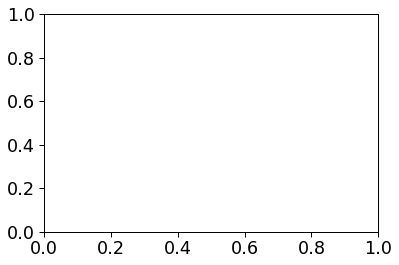

In [453]:
for i in range(5):
    plt.bar(range(230),df.sample(1).iloc[0,2:].values)
    plt.title('Original')
    plt.show()

## Compare Distances

In [508]:
trial_data = df.values.astype(float)
trial_data_tf = tf.convert_to_tensor(trial_data)
output = autoencoder.predict(trial_data_tf,steps=10)

In [509]:
predictionDistances = []

for nn in range(trial_data.shape[0]):
    predictionDistances.append(distance.cosine(output[nn],trial_data[nn,:]))

In [510]:
%%time

pairwiseDistances = []
minDistances = []

if isTasks:
    nn = trial_data.shape[0]
else:
    nn = 3600

for i in range(trial_data.shape[0])[0:nn]:
    tempDistances = np.ones(nn)
    
    for j in range(trial_data.shape[0])[0:nn]:
        tempDistance = distance.cosine(trial_data[i,:],trial_data[j,:])
        pairwiseDistances.append(tempDistance)
        
        if not i == j:
            tempDistances[j] = tempDistance
        
    minDistances.append(np.min(tempDistances))

CPU times: user 24.9 s, sys: 142 ms, total: 25.1 s
Wall time: 25.2 s


In [402]:
%%time

sampleDistances = []

for n in range(100):
    latentActivations = np.random.random(size=(1,nLatent))
    sample_data = tf.convert_to_tensor(latentActivations)

    output = decoder_model.predict(sample_data,steps=10)
    
    distances = np.zeros(trial_data.shape[0])
    
    for i in range(trial_data.shape[0]):
        distances[i] = distance.cosine(trial_data[i,:],output[0])
    
    sampleDistances.append(np.min(distances))

CPU times: user 2min 30s, sys: 17 s, total: 2min 47s
Wall time: 2min 48s


(0.0, 0.4)

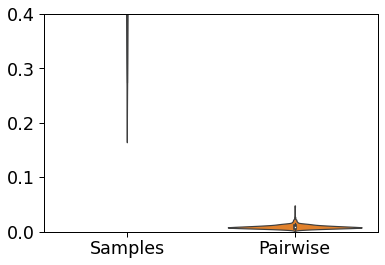

In [408]:
sns.violinplot(data=[sampleDistances,minDistances])
plt.xticks([0,1],['Samples','Pairwise'])
plt.ylim(0,0.4)

In [71]:
print('Sample Mean = {:.3f}'.format(np.mean(sampleDistances)))
print('Pairwise Mean = {:.3f}'.format(np.mean(minDistances)))

Sample Mean = 0.033
Pairwise Mean = 0.042


/Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


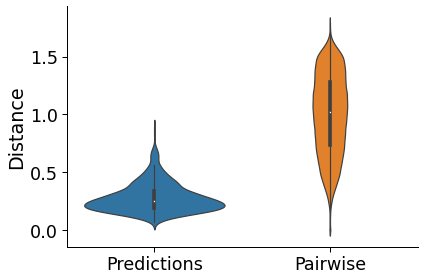

In [694]:
fig, ax = plt.subplots()

sns.violinplot(data=[predictionDistances,pairwiseDistances])
plt.xticks([0,1],['Predictions','Pairwise'])
plt.ylabel('Distance')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figs/predictions_pairwise_boxplot.png', dpi = 300, tight_layout = True)

In [572]:
print('Predictions Mean = {:.3f}'.format(np.mean(predictionDistances)))
print('Pairwise Mean = {:.3f}'.format(np.mean(minDistances)))

Predictions Mean = 0.281
Pairwise Mean = 0.252
